In [120]:
device = 'cpu'
import shap

In [95]:
from torch.autograd import Variable

In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
#import PyWavelets
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
#from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import joblib
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
import sklearn

import warnings
warnings.filterwarnings("ignore")

In [3]:
#torch.cuda.get_device_name()

In [4]:
torch.cuda.is_available()

False

### Load ICS Data

In [5]:
# Load ICS data from University of Michigan repository
ics_monthly = pd.read_csv('http://www.sca.isr.umich.edu/files/tbmics.csv')
ics_monthly = ics_monthly.dropna()
ics_monthly = ics_monthly[-200:]
ics_monthly.head()

,Month,YYYY,ICS_ALL
437,October,2006,93.6
438,November,2006,92.1
439,December,2006,91.7
440,January,2007,96.9
441,February,2007,91.3


In [6]:
# Construct date column from year, month and date
ics_monthly["date"] = np.nan
for i in range(len(ics_monthly)):
    ics_monthly.iloc[i, 3] = pd.to_datetime((str(ics_monthly.iloc[i,1]) + '-' + str(ics_monthly.iloc[i,0])))
ics_monthly = ics_monthly.dropna()
ics_monthly["date"] = pd.to_datetime(ics_monthly.date)

In [7]:
# Convert monthly ics data into daily csi data
ics_monthly.index = ics_monthly.date
dates = pd.date_range(ics_monthly.date.min(), ics_monthly.date.max(), freq='D')
ics_daily = ics_monthly.reindex(dates, method='ffill')
ics_daily["date"] = ics_daily.index
ics_daily.drop(["Month", "YYYY"], axis = 1, inplace=True)
del dates

In [8]:
ics_daily.head()

,ICS_ALL,date
2006-10-01,93.6,2006-10-01
2006-10-02,93.6,2006-10-02
2006-10-03,93.6,2006-10-03
2006-10-04,93.6,2006-10-04
2006-10-05,93.6,2006-10-05


### CPI data

In [9]:
cpi_monthly = pd.read_excel("../data/m5-forecasting-accuracy/macro-data/CPI-data.xlsx")

In [10]:
cpi_monthly.head()

,year-month,cpi
0,197001,15.9
1,197002,16.0
2,197003,16.1
3,197004,16.2
4,197005,16.3


In [11]:
# Construct date column from year and month
cpi_monthly["date"] = np.nan
for i in range(len(cpi_monthly)):
    cpi_monthly.iloc[i, 2] = pd.to_datetime(str(cpi_monthly.iloc[i,0])[:4] + '-' + str(cpi_monthly.iloc[i,0])[4:])
cpi_monthly["date"] = pd.to_datetime(cpi_monthly.date)

In [12]:
# Convert monthly cpi data into daily data
cpi_monthly.index = cpi_monthly.date
dates = pd.date_range(cpi_monthly.date.min(), cpi_monthly.date.max(), freq='D')
cpi_daily = cpi_monthly.reindex(dates, method='ffill')
cpi_daily["date"] = cpi_daily.index
cpi_daily.drop(["year-month"], axis = 1, inplace=True)
del dates

In [13]:
cpi_daily.head()

,cpi,date
1970-01-01,15.9,1970-01-01
1970-01-02,15.9,1970-01-02
1970-01-03,15.9,1970-01-03
1970-01-04,15.9,1970-01-04
1970-01-05,15.9,1970-01-05


### Unemployment data

In [14]:
unemp_yearly = pd.read_csv("../data/m5-forecasting-accuracy/macro-data/unemployment-data.csv")

In [15]:
unemp_yearly.head()

,year,unemp
0,1991,6.80
1,1992,7.50
2,1993,6.90
3,1994,6.12
4,1995,5.65


In [16]:
# Construct date column from year and month
unemp_yearly["date"] = np.nan
for i in range(len(unemp_yearly)):
    unemp_yearly.iloc[i, 2] = pd.to_datetime(str(unemp_yearly.iloc[i,0]) + '-' + '01-01')
unemp_yearly["date"] = pd.to_datetime(unemp_yearly.date)

In [17]:
# Convert yearly unemployment data into daily data
unemp_yearly.index = unemp_yearly.date
dates = pd.date_range(unemp_yearly.date.min(), unemp_yearly.date.max(), freq='D')
unemp_daily = unemp_yearly.reindex(dates, method='ffill')
unemp_daily["date"] = unemp_daily.index
unemp_daily.drop(["year"], axis = 1, inplace=True)
del dates

In [18]:
unemp_daily.head()

,unemp,date
1991-01-01,6.8,1991-01-01
1991-01-02,6.8,1991-01-02
1991-01-03,6.8,1991-01-03
1991-01-04,6.8,1991-01-04
1991-01-05,6.8,1991-01-05


In [19]:
macro_data = ics_daily.merge(cpi_daily,on='date',how="left").merge(unemp_daily,on='date',how="left")

In [20]:
macro_data.head()

,ICS_ALL,date,cpi,unemp
0,93.6,2006-10-01,85.1,4.62
1,93.6,2006-10-02,85.1,4.62
2,93.6,2006-10-03,85.1,4.62
3,93.6,2006-10-04,85.1,4.62
4,93.6,2006-10-05,85.1,4.62


In [25]:
macro_data = macro_data.rename(columns = {"ICS_ALL": "ics"})

In [26]:
macro_data.head()

,ics,date,cpi,unemp
0,93.6,2006-10-01,85.1,4.62
1,93.6,2006-10-02,85.1,4.62
2,93.6,2006-10-03,85.1,4.62
3,93.6,2006-10-04,85.1,4.62
4,93.6,2006-10-05,85.1,4.62


In [27]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Data Preprocessing

#### Load Data

In [28]:
def read_data(PATH):
    print('Reading files...')
    calendar = pd.read_csv(f'{PATH}/calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(f'{PATH}/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(f'{PATH}/sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv(f'{PATH}/sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission

In [37]:
calendar, sell_prices, sales_train_validation, submission = read_data("../data/m5-forecasting-accuracy")

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns


In [38]:
calendar["date"] = pd.to_datetime(calendar.date)

In [39]:
# Merge sale data with csi data and drop columns that are not needed
calendar_macro = calendar.merge(macro_data, on=["date"], how="left")

In [40]:
calendar_macro.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,ics,cpi,unemp
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,74.2,92.9,8.95
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,74.2,92.9,8.95
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,74.2,92.9,8.95
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,77.5,93.4,8.95
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,77.5,93.4,8.95


In [41]:
sales_train_validation[sales_train_validation.cat_id=="FOODS"].head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
1612,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,...,0,2,0,4,1,1,0,1,1,0
1613,FOODS_1_002_CA_1_validation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,1,0,1,...,1,3,1,0,0,1,2,0,0,0
1614,FOODS_1_003_CA_1_validation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,3,0,2,1,1,0,1,0,1,0
1615,FOODS_1_004_CA_1_validation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1616,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,9,3,3,...,3,1,1,2,0,2,2,1,4,1


In [42]:
sales_train_validation_melt = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='demand')

In [44]:
sales_CA_1 = sales_train_validation_melt[sales_train_validation_melt.store_id == "CA_1"]
#sales_CA_1 = sales_train_validation_melt[sales_train_validation_melt.store_id == "CA_1"][sales_train_validation.item_id=='FOODS_1_005']
new_CA_1 = pd.merge(sales_CA_1, calendar_macro, left_on="day", right_on="d", how="left")
new_CA_1 = pd.merge(new_CA_1, sell_prices, left_on=["store_id", "item_id", "wm_yr_wk"],right_on=["store_id", "item_id", "wm_yr_wk"], how="left")
new_CA_1["day_int"] = new_CA_1.day.apply(lambda x: int(x.split("_")[-1]))

In [46]:
new_CA_1=new_CA_1[new_CA_1.item_id=='FOODS_1_005']

In [47]:
new_CA_1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,ics,cpi,unemp,sell_price,day_int
1616,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,1
4665,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_2,9,2011-01-30,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,2
7714,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_3,3,2011-01-31,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,3
10763,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_4,3,2011-02-01,11101,...,NaN,NaN,1,1,0,77.5,93.4,8.95,2.939453,4
13812,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_5,0,2011-02-02,11101,...,NaN,NaN,1,0,1,77.5,93.4,8.95,2.939453,5


In [48]:
new_CA_1.shape

(1913, 27)

### Modeling

In [49]:
# take only one stor for demo
CA1 = new_CA_1
CA1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,date,wm_yr_wk,...,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,ics,cpi,unemp,sell_price,day_int
1616,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_1,3,2011-01-29,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,1
4665,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_2,9,2011-01-30,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,2
7714,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_3,3,2011-01-31,11101,...,NaN,NaN,0,0,0,74.2,92.9,8.95,2.939453,3
10763,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_4,3,2011-02-01,11101,...,NaN,NaN,1,1,0,77.5,93.4,8.95,2.939453,4
13812,FOODS_1_005_CA_1_validation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,d_5,0,2011-02-02,11101,...,NaN,NaN,1,0,1,77.5,93.4,8.95,2.939453,5


In [51]:
cols = ["item_id","day_int", "demand", "sell_price", "date", "ics", "cpi", "unemp"]
CA1 = CA1[cols]
CA1.fillna(0, inplace=True)
print(CA1.shape)
CA1.head()

(1913, 8)


,item_id,day_int,demand,sell_price,date,ics,cpi,unemp
1616,FOODS_1_005,1,3,2.939453,2011-01-29,74.2,92.9,8.95
4665,FOODS_1_005,2,9,2.939453,2011-01-30,74.2,92.9,8.95
7714,FOODS_1_005,3,3,2.939453,2011-01-31,74.2,92.9,8.95
10763,FOODS_1_005,4,3,2.939453,2011-02-01,77.5,93.4,8.95
13812,FOODS_1_005,5,0,2.939453,2011-02-02,77.5,93.4,8.95


### Feature Engineering

In [52]:
def date_features(df):
    
    #df["date"] = pd.to_datetime(df["date"])
    df["day"] = df.date.dt.day
    df["month"] = df.date.dt.month
    df["week_day"] = df.date.dt.weekday

    df.drop(columns="date", inplace=True)

    return df

def sales_features(df):

    df.sell_price.fillna(0, inplace=True)

    return df

def demand_features(df):

    df["lag_t28"] = df["demand"].transform(lambda x: x.shift(28))
    df["rolling_mean_t7"] = df["demand"].transform(lambda x:x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df['demand'].transform(lambda x: x.shift(28).rolling(30).std())

    df.fillna(0, inplace=True)

    return df

In [53]:
CA1=date_features(CA1)

In [54]:
CA1=sales_features(CA1)

In [56]:
CA1=demand_features(CA1)

In [57]:
CA1.head()

,item_id,day_int,demand,sell_price,ics,cpi,unemp,day,month,week_day,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
1616,FOODS_1_005,1,3,2.939453,74.2,92.9,8.95,29,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4665,FOODS_1_005,2,9,2.939453,74.2,92.9,8.95,30,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7714,FOODS_1_005,3,3,2.939453,74.2,92.9,8.95,31,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10763,FOODS_1_005,4,3,2.939453,77.5,93.4,8.95,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13812,FOODS_1_005,5,0,2.939453,77.5,93.4,8.95,2,2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
x = CA1.drop(["item_id", "day_int"], axis =1)[:-1]

In [70]:
y = CA1.shift(-1)["demand"][:-1]

In [71]:
columns = x.columns

In [85]:
x.shape, y.shape

((1912, 16), (1912,))

In [105]:
y_np = np.reshape(np.array(y), (y.shape[0],1))

In [107]:
x_np = np.reshape(np.array(x), (x.shape[0],x.shape[1], 1))

In [108]:
x_np.shape, y_np.shape

((1912, 16, 1), (1912, 1))

In [109]:
train_size = int(len(y_np) * 0.67)
test_size = len(y_np) - train_size

dataX = Variable(torch.Tensor(np.array(x_np)))
dataY = Variable(torch.Tensor(np.array(y_np)))

trainX = Variable(torch.Tensor(np.array(x_np[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y_np[0:train_size])))

testX = Variable(torch.Tensor(np.array(x_np[train_size:len(x_np)])))
testY = Variable(torch.Tensor(np.array(y_np[train_size:len(y_np)])))

In [110]:
trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([1281, 16, 1]),
 torch.Size([1281, 1]),
 torch.Size([631, 16, 1]),
 torch.Size([631, 1]))

In [111]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [112]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [113]:
#####  Parameters  ######################
num_epochs = 100
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in range(num_epochs): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

Epoch: 0, loss: 5.96941 valid loss:  4.35074 
Epoch: 50, loss: 4.60376 valid loss:  3.23640 


In [116]:
#RMSE
lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()
np.sqrt(((dataY_plot[-testX.size()[0]:] - data_predict[-testX.size()[0]:] ) ** 2).mean())

1.8410709

In [118]:
background = dataX[np.random.choice(dataX.shape[0], 100, replace=False)]
background2 = trainX[np.random.choice(trainX.shape[0], 200, replace=False)]

In [121]:
explainer = shap.DeepExplainer(lstm, background)
shap_values = explainer.shap_values(background2)

In [124]:
background2.shape

torch.Size([200, 16, 1])

In [126]:
sv = pd.DataFrame(np.reshape(shap_values, (200,16)))
bg2 = pd.DataFrame(np.reshape(background2, (200,16)), columns=columns)
bg2.head()

,demand,sell_price,ics,cpi,unemp,day,month,week_day,lag_t28,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_std_t7,rolling_std_t30
0,0.0,2.939453,63.700001,95.300003,8.95,9.0,7.0,5.0,0.0,0.000000,0.233333,1.733333,1.711111,0.000000,7.884953e-08,0.817200
1,0.0,3.279297,72.900002,96.900002,8.07,29.0,12.0,5.0,1.0,0.571429,1.500000,2.633333,2.877778,2.050000,7.867958e-01,2.129432
2,1.0,2.939453,67.500000,94.300003,8.95,31.0,3.0,3.0,0.0,1.571429,2.433333,0.000000,0.000000,0.000000,1.511858e+00,3.036370
3,0.0,3.279297,76.400002,98.099998,7.37,2.0,4.0,1.0,0.0,0.714286,1.966667,1.900000,1.955556,2.366667,7.559289e-01,2.235811
4,4.0,3.279297,69.900002,95.199997,8.95,21.0,12.0,2.0,1.0,0.714286,1.833333,3.100000,3.188889,1.666667,1.112697e+00,1.858500


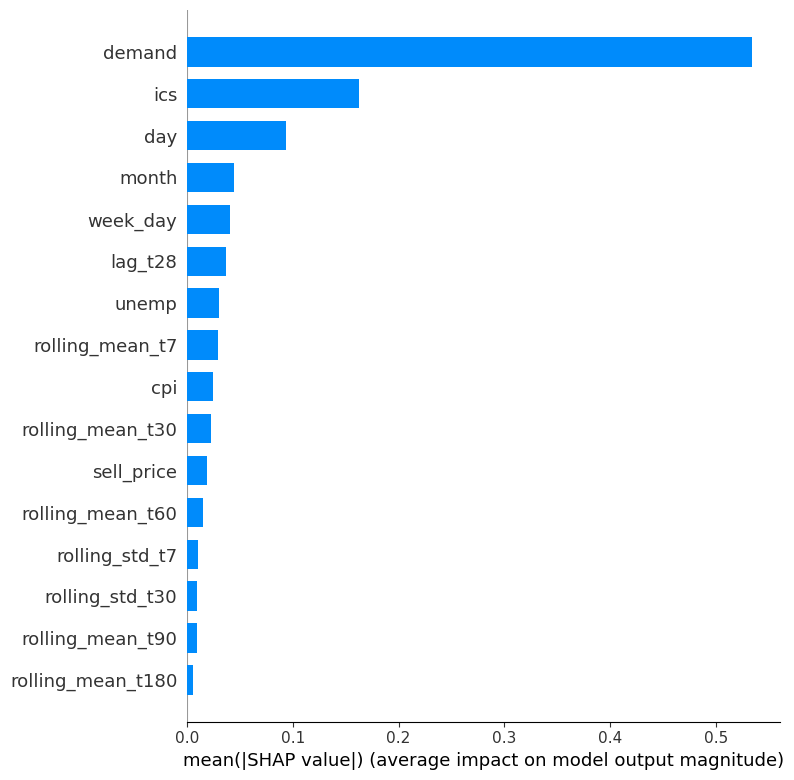

In [143]:
fig = shap.summary_plot(sv, bg2, plot_type="bar", max_display = bg2.shape[1], show=False)
#plt.title("Shap values (feature importance)")
plt.savefig("shap.jpeg", dpi=150, bbox_inches='tight')